Silent substitution with STLAB
==============================

[Silent substitution](https://www.frontiersin.org/articles/10.3389/fneur.2018.00941/full) is an elegant technique that uses pairs of lights to stimulate a specific class of retinal photoreceptor whilst maintaining a constant level of activation in others. The challenge with this technique is finding the settings for a stimulation device to produce light stimuli that satisfy the spectral requirements and constraints. Suppose we are interested in how the melanopsin-containing ipRGCs contribute to pupil control and that we want to administer a light stimulus that targets melanopsin without changing the activation of the cone photoreceptors, so as to be sure that the resulting pupil modulation is driven purely by ipRGC activity. For simplicity's sake we can assume the rods are saturated. To accomplish our goal we need to find the settings for a background spectrum and a modulation spectrum where both spectra have identical S-, M-, and L-opic irradiance, but where the modulation spectrum has higher melanopic irradiance. Fundamentally, this is a constrained numerical optimisation problem that can be expressed formally as:

\begin{equation}
\begin{array}{rrclcl}
& \underset{x}{\text{minimize}}
& & f(x) \\
& \text{subject to}
& & g^{L} \le g(x) \le g^{U}
\end{array}
\end{equation}

where $f(x)$ is the objective function which aims to minimise negative (i.e., maximise) melanopsin contrast, and $g(x)$ is a function that calculates cone contrast, where $g^{L}$ and $g^{U}$ should be zero. In both cases, $x$ is a vector containing the weights for the LED settings. What follows is a basic example of how to find a solution to this problem for STLAB, which has 10 LED channels.

First, we create a calibration context which gives us access to the forward model of STLAB.

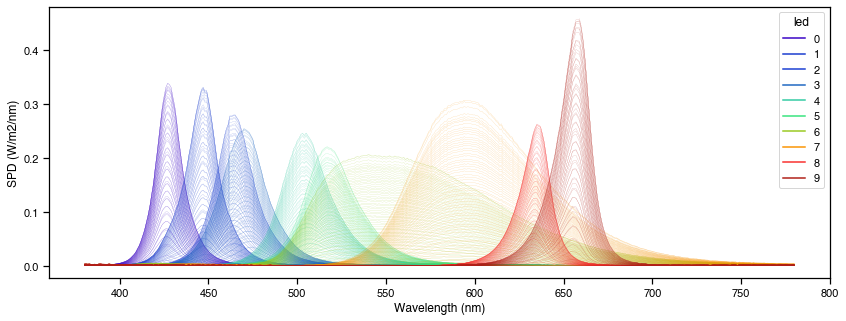

In [2]:
import seaborn as sns
from pyplr.calibrate import CalibrationContext
sns.set_context('notebook')

cc = CalibrationContext(
    data='../data/S2_corrected_oo_spectra.csv', binwidth=1)
fig = cc.plot_calibrated_spectra()

Now we can define the problem. The approach used here is to encapsulate the problem in a class with the *a*-opic irradiance data for STLAB. Note that contrast is defined simply as the fractional difference of activation of a photopigment around a background:

\begin{equation}
\frac{I_{modulation} − I_{background}}{I_{background}}
\end{equation}


In [3]:
from scipy.interpolate import interp1d

class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights. 
        The first 10 values in weights define the background 
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10] 
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led]) 
        return (pd.Series(bg_smlri, index=self.aopic.columns),
                pd.Series(mod_smlri, index=self.aopic.columns))

    def objective_function(self, weights):
        '''Calculates negative melanopsin contrast for background 
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.Mel-bg_smlri.Mel) / bg_smlri.Mel
        return -contrast

    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background 
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S, 
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M, 
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in res.x[0:10]], 
                [int(val*4095) for val in res.x[10:20]])

To perform the optimisation, we will use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) with the [SLSQP](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) solver. SLSQP uses [sequential quadratic programming](https://en.wikipedia.org/wiki/Sequential_quadratic_programming), an iterative method that is ideally suited to solving constrained nonlinear optimsation problems like ours. 

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds
from pyplr.CIE import get_CIES026

# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0]

# The aopic data from original spectrometer measurements
sss = get_CIES026(asdf=True)
sss.fillna(0, inplace=True)
aopic = cc.data.dot(sss)

# Create an instance of our optimisation problem
op = OptimisationProblem(aopic)

# Define and equality constraint for the cones 
# (i.e., contrast must be zero)
constraints = {
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
}   

# The bounds should be between 0-1, otherwise we are outside the 
# gamut of the device
bounds = Bounds(np.ones((20))*0, np.ones((20))*1) 

# Do the optimsation
res = minimize(op.objective_function, 
               x0, 
               method='SLSQP', 
               constraints=constraints,
               options={'maxiter': 1000},
               bounds=bounds)

# Print the result
print('Optimisation result:')
print(res)

# Print contrast for results
print('Melanopsin contrast is: {}'.format(
    op.objective_function(res.x)))
print('Cone contrast is: {}'.format(
    op.cone_contrast_constraint_function(res.x)))



Optimisation result:
     fun: -1.1262980001283986
     jac: array([ 1.68524863e+00,  3.15193579e-01,  1.72366345e+00,  1.94611071e+00,
        1.02473636e+00,  2.61568606e-01,  1.12671651e+00,  2.99931169e-01,
        1.14196539e-03,  6.18398190e-04, -1.88550070e-01, -7.49940321e-01,
       -1.89080393e+00, -1.62490889e-01, -1.57686652e+00, -1.23016015e-01,
       -2.05165818e-01, -2.35104889e-01, -2.52726525e-02, -5.31006455e-02])
 message: 'Optimization terminated successfully'
    nfev: 2114
     nit: 94
    njev: 94
  status: 0
 success: True
       x: array([2.72832879e-01, 5.55555807e-01, 6.44788109e-14, 7.33560916e-14,
       3.21556559e-12, 4.75574157e-14, 3.11704172e-01, 3.48394141e-01,
       7.47335280e-13, 1.86972226e-15, 3.24115162e-13, 5.59009258e-04,
       2.52874586e-01, 7.16086550e-01, 4.24668885e-01, 2.25413334e-13,
       4.38771435e-13, 2.51358975e-01, 9.80844739e-01, 1.00000000e+00])
Melanopsin contrast is: -1.1262980001283986
Cone contrast is: [2.77454853e-11 2.

Success. The optimisation has found a result where cones are silent and melanopsin contrast is 112%. We can~ plot the spectra and *a*-opic irradiances to see what the solution looks like.

The background settings are: [1117, 2275, 0, 0, 0, 0, 1276, 1426, 0, 0]
The modulation settings are: [0, 2, 1035, 2932, 1739, 0, 0, 1029, 4016, 4094]


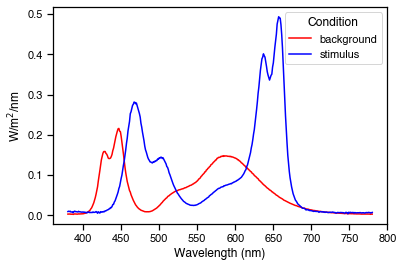

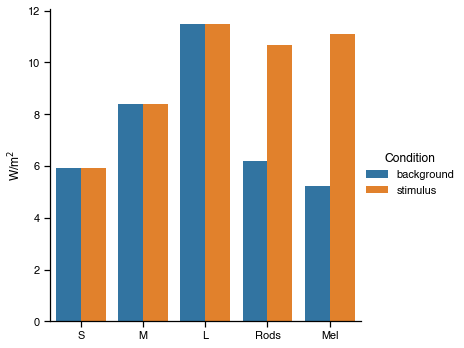

In [5]:
import matplotlib.pyplot as plt

# Convert the solution to 12-bit device settings for STLAB
background_settings, modulation_settings = op.weights_to_settings(res.x)
print(f'The background settings are: {background_settings}')
print(f'The modulation settings are: {modulation_settings}')

# Predict the spectral power distributions
background_spec = cc.predict_spd(background_settings).squeeze()
modulation_spec = cc.predict_spd(modulation_settings).squeeze()

# Predict aopic irradiances
background_ao = cc.predict_aopic(background_settings)
modulation_ao = cc.predict_aopic(modulation_settings)
ao = pd.concat([background_ao, modulation_ao])
ao = ao.reset_index(drop=True)
ao['Condition'] = ['background', 'stimulus']
ao = ao.melt(id_vars='Condition')

# Plot the predicted spectra
fig, ax = plt.subplots()
wls = np.arange(380, 781)
ax.plot(wls, background_spec, c='r', label='background')
ax.plot(wls, modulation_spec, c='b', label='stimulus')
ax.set(ylabel='W/m$^2$/nm',
       xlabel='Wavelength (nm)')
ax.legend(title='Condition')

# Plot the predicted a-opic irradiances
ax2 = sns.catplot(data=ao, x='variable', y='value', 
                  kind='bar', hue='Condition')
ax2.set(ylabel='W/m$^2$',
        xlabel='');


This is a good start, but it is unlikely to be the exact solution we are looking for, as SciPy's SLSQP solver is a 'local' minimzer. This means that it will attempt to locate the nearest minimum to its starting point, which in our case was completely random. Suppose for example that we wanted our melanopic pulse to be at least 400% contrast. For this we would need to search for a better solution using ['global' optimisation](https://en.wikipedia.org/wiki/Global_optimization). One approach is to use SciPy's [basinhopping](https://en.wikipedia.org/wiki/Basin-hopping) algorithm in conjunction with the SLSQP solver. This will conduct a series of local minimisations, each time starting at a different coordinates in the problem space. We can save all of the acceptable intermediate solutions and call off the search when we find a solution that has at least 400% melanopic contast. 

In [6]:
from scipy.optimize import basinhopping

# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0]

# The aopic data from original spectrometer measurements
sss = get_CIES026(asdf=True)
sss.fillna(0, inplace=True)
aopic = cc.data.dot(sss)

# Create an instance of our optimisation problem
op = OptimisationProblem(aopic)

# Define bounds of 0-1, which makes sure the settings are
# within the gamut of STLAB
bounds = Bounds(np.ones((20))*0, np.ones((20))*1)

# Define constraints and local minimizer
constraints = {'type': 'eq',
               'fun': lambda x: op.cone_contrast_constraint_function(x)}

minimizer_kwargs = {'method': 'SLSQP',
                    'constraints': constraints,
                    'bounds': bounds,
                    'options': {'maxiter': 100}
                   }

# List to store valid solutions
minima = []

# Callback function to give info on all minima found and 
# call off the search when we hit a target melanopic contrast
def print_fun(x, f, accepted):
    print(f"Melanopsin contrast at minimum: {f}, accepted {accepted}")
    if accepted:
        minima.append(x)
        if f < -4. and accepted: # the target is 400% contrast
            return True
    
# Start the global search
res = basinhopping(op.objective_function, 
                   x0,
                   minimizer_kwargs=minimizer_kwargs,
                   niter=100,
                   stepsize=0.5, 
                   callback=print_fun)

Melanopsin contrast at minimum: -1.157205714211695, accepted True
Melanopsin contrast at minimum: -1.0333207541135296, accepted True
Melanopsin contrast at minimum: -1.1463763700733014, accepted True
Melanopsin contrast at minimum: -1.349362878365679, accepted True
Melanopsin contrast at minimum: -1.3000577322404925, accepted True
Melanopsin contrast at minimum: -1.6298963642832545, accepted True
Melanopsin contrast at minimum: -1.5531614465469152, accepted True
Melanopsin contrast at minimum: -1.6402950219928798, accepted True
Melanopsin contrast at minimum: -1.5055464302170414, accepted False
Melanopsin contrast at minimum: -2.5376813025601095, accepted True
Melanopsin contrast at minimum: -0.7473887793354929, accepted True
Melanopsin contrast at minimum: -1.7741800855251268, accepted True
Melanopsin contrast at minimum: -2.113277220497712, accepted True
Melanopsin contrast at minimum: -2.195097542530537, accepted True
Melanopsin contrast at minimum: -1.9454096886092744, accepted Tru

Good. We have found a solution that gives 462% melanopic contrast. As before, we can plot the spectra and *a*-opic irradiances to see how they look.

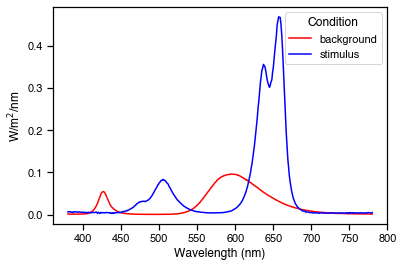

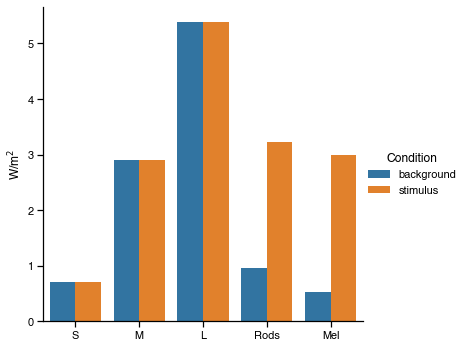

In [7]:
import matplotlib.pyplot as plt

# Convert the solution to 12-bit device settings for STLAB
background_settings, modulation_settings = op.weights_to_settings(res.x)

# Predict the spectral power distributions
background_spec = cc.predict_spd(background_settings).squeeze()
modulation_spec = cc.predict_spd(modulation_settings).squeeze()

# Predict aopic irradiances
background_ao = cc.predict_aopic(background_settings)
modulation_ao = cc.predict_aopic(modulation_settings)
ao = pd.concat([background_ao, modulation_ao])
ao = ao.reset_index(drop=True)
ao['Condition'] = ['background', 'stimulus']
ao = ao.melt(id_vars='Condition')

# Plot the predicted spectra
fig, ax = plt.subplots()
wls = np.arange(380, 781)
ax.plot(wls, background_spec, c='r', label='background')
ax.plot(wls, modulation_spec, c='b', label='stimulus')
ax.set(ylabel='W/m$^2$/nm',
       xlabel='Wavelength (nm)')
ax.legend(title='Condition')

# Plot the predicted a-opic irradiances
ax2 = sns.catplot(data=ao, x='variable', y='value', 
                  kind='bar', hue='Condition')
ax2.set(ylabel='W/m$^2$',
        xlabel='');


After conducting some spectral validations to check that STLAB reproduces these stimuli faithfully, all that remains is to make video files for the presentation. Here we make a video file that will present a 2 second melanopic pulse half way through a minute of the background spectrum. 

In [8]:
from pyplr.stlab import background_pulse_protocol

# Print the settings and make video files
print('The background settings are: {}'.format(background_settings))
print('The stimulus settings are: {}'.format(modulation_settings))
background_pulse_protocol(background_spec=background_settings,
                          pre_pulse_duration=29,
                          pulse_spec=modulation_settings,
                          pulse_duration=2,
                          post_pulse_duration=29,
                          fname='melanopsin_pulse')

The background settings are: [454, 0, 0, 0, 0, 0, 0, 1393, 0, 0]
The stimulus settings are: [0, 0, 0, 236, 1061, 0, 0, 0, 3834, 4094]
"melanopsin_pulse.dsf" saved in the current working directory.
